# <font color="red">Лабораторная работа 3: Семантическая сегмантация на примере DeepLabV3+ (ResNet‑101) и SAM2</font>

Сегментация изображений — это задача компьютерного зрения, заключающаяся в разделении изображения на однородные области, соответствующие объектам или их частям. В отличие от задачи классификации, где модель присваивает всему изображению один класс, и задачи детекции, где определяются ограничивающие рамки объектов, семантическая сегментация нацелена на присвоение классу каждому пикселю изображения.

Классические методы семантической сегментации основаны на свёрточных нейронных сетях (CNN). Среди них наиболее популярны архитектуры семейства FCN, U-Net, DeepLab. Их ключевые особенности:

- Иерархическое извлечение признаков: свёрточные слои постепенно расширяют область восприятия (receptive field).

- Пулинг и апсемплинг: понижение разрешения (pooling) для захвата глобального контекста и последующее восстановление пространственного разрешения (upsampling).

- Расширенные свертки (atrous свертки): позволяют увеличить область восприятия без увеличения числа параметров.

# Методы семантической сегментации

## CNN
Классические методы семантической сегментации основаны на свёрточных нейронных сетях (CNN). Среди них наиболее популярны архитектуры семейства FCN, U-Net, DeepLab. Их ключевые особенности:

Иерархическое извлечение признаков: свёрточные слои постепенно расширяют область восприятия (receptive field).

Пулинг и апсемплинг: понижение разрешения (pooling) для захвата глобального контекста и последующее восстановление пространственного разрешения (upsampling).

Расширенные свертки (atrous свертки): позволяют увеличить область восприятия без увеличения числа параметров.

## Transformer-подходы

Transformers, изначально завоевавшие успех в NLP, были адаптированы для обработки изображений (Vision Transformers, ViT). Основная идея — разбить изображение на патчи и воспринимать их как последовательность токенов.

В контексте сегментации появились два класса подходов:

- Чистые трансформеры: используют attention для глобального взаимодействия патчей;

- Гибридные модели: комбинируют CNN-экстрактор признаков и трансформер для семантики.

SAM v2 (Segment Anything Model) — пример zero-shot-сегментатора, то есть способного справляться с задачей выделения объектов на изображении без дополнительного обучения на данных из конкретного домена. В нем используется:

- ViT backbone для извлечения патч-эмбеддингов;

- Mask Decoder с использованием перекрёстного внимания (cross-attention) между патчами и обучаемые запросы learnable queries;

- Automatic Mask Generator генерирует несколько масок и агрегирует их.

Преимущества Transformer-моделей:

Zero-shot способность сегментировать широкий круг объектов;

Глобальный контекст благодаря attention.

Недостатки:

Большие модели требуют значительных вычислений;

В zero-shot-режиме бывает избыточная генерация непонятных масок;

Меньше детализация мелких объектов без дообучени

## Установка зависимостей

In [ ]:
!pip -q install --upgrade torch torchvision torchaudio
!pip -q install opencv-python-headless matplotlib tqdm
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!pip install fastai==2.7.19

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 137.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import torch, torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Subset

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, os, urllib.request, json

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from IPython import get_ipython
from IPython.display import display
from PIL import Image
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {DEVICE}")

torch.manual_seed(42)
random.seed(42)

Используемое устройство: cuda


# Конфигурация и вспомогательные функции
## Параметры эксперимента (изменяйте при необходимости)

In [ ]:
N_SAMPLES      = 100   # количество изображений для быстрой оценки (уменьшайте, если не хватает памяти)
VISUALIZE_N    = 3     # сколько примеров визуализировать
CAT_CLASSES    = [8]   # PASCAL class id для "cat" в DeepLabV3
DOG_CLASSES    = [12]  # PASCAL class id для "dog" в DeepLabV3
TARGET_CLASSES = CAT_CLASSES + DOG_CLASSES

# Метрики --------------------------------------------------------------------
def compute_iou(pred: np.ndarray, target: np.ndarray) -> float:
    """IoU для бинарных масок (bool numpy)."""
    intersection = np.logical_and(pred, target).sum()
    union        = np.logical_or(pred, target).sum()
    if union == 0:
        return np.nan
    return intersection / union


def compute_dice(pred: np.ndarray, target: np.ndarray) -> float:
    """Dice/F1 для бинарных масок."""
    intersection = np.logical_and(pred, target).sum()
    size_sum     = pred.sum() + target.sum()
    if size_sum == 0:
        return np.nan
    return 2 * intersection / size_sum

# Визуализация ----------------------------------------------------------------
COLORS = {
    "gt": (0, 255, 0),        # зелёный — ground truth
    "deeplab": (255, 0, 0),   # красный — DeepLabV3+
    "sam": (0, 0, 255),       # синий — SAM
}

def overlay_mask(img: np.ndarray, mask: np.ndarray, color, alpha: float = 0.5):
    """Наложение полупрозрачной маски на изображение."""
    overlay = img.copy()
    overlay[mask] = overlay[mask] * (1 - alpha) + np.array(color) * alpha
    return overlay.astype(np.uint8)


def show_examples(examples, figsize=(15, VISUALIZE_N * 3)):
    """Вывод VISUALIZE_N примеров (img, gt, dl_mask, sam_mask)"""
    plt.figure(figsize=figsize)
    for i, (img, gt, dl, sam) in enumerate(examples):
        # Оригинал + GT
        plt.subplot(VISUALIZE_N, 3, i * 3 + 1)
        plt.title("Исходное + GT")
        plt.axis("off")
        plt.imshow(overlay_mask(img, gt, COLORS["gt"]))

        # DeepLab
        plt.subplot(VISUALIZE_N, 3, i * 3 + 2)
        plt.title("DeepLabV3+")
        plt.axis("off")
        plt.imshow(overlay_mask(img, dl, COLORS["deeplab"]))

        # SAM
        plt.subplot(VISUALIZE_N, 3, i * 3 + 3)
        plt.title("SAM v2")
        plt.axis("off")
        plt.imshow(overlay_mask(img, sam, COLORS["sam"]))
    plt.tight_layout()
    plt.show()

## Загрузка датасета


In [ ]:
IMG_SIZE = 384  # приведение к квадрату для ускорения работы

transform_dl = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_sam = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
])

class PetSegDataset(torch.utils.data.Dataset):
    def __init__(self, root, n_samples):
        ds = OxfordIIITPet(root=root, split="trainval", target_types="segmentation",
                           download=True, transforms=None)
        indices = random.sample(range(len(ds)), n_samples)
        self.subset = Subset(ds, indices)

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, mask = self.subset[idx]
        # GT: 1=pet, 2=border → положительный класс; всё остальное — фон
        gt = np.array(mask)
        gt_bin = np.isin(gt, [1, 2])

        # DeepLab
        img_dl = transform_dl(img)

        # SAM expects RGB numpy uint8
        img_sam = np.array(transform_sam(img))

        # Resize the ground truth mask to match the DeepLab input size
        gt_bin = transforms.Resize((IMG_SIZE, IMG_SIZE))(Image.fromarray(gt_bin.astype(np.uint8)))
        gt_bin = np.array(gt_bin) > 0 # convert back to boolean

        return img_dl, img_sam, gt_bin

# Загружаем данные -----------------------------------------------------------
DATA_ROOT = "./data"
dataset = PetSegDataset(DATA_ROOT, N_SAMPLES)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
print(f"Датасет готов: {len(dataset)} изображений")

100%|██████████| 792M/792M [00:49<00:00, 15.9MB/s]
100%|██████████| 19.2M/19.2M [00:02<00:00, 8.12MB/s]


Датасет готов: 100 изображений


# DeepLabV3+ (ResNet‑101)

## Загружаем модель, предобученную на PASCAL VOC 21

In [ ]:
model_dl = torchvision.models.segmentation.deeplabv3_resnet101(weights="DEFAULT")
model_dl = model_dl.to(DEVICE).eval()

ious_dl, dices_dl = [], []
examples = []

with torch.no_grad():
    for idx, (img_dl, img_sam, gt_bin) in enumerate(tqdm(dataloader)):
        img_dl = img_dl.to(DEVICE)
        out = model_dl(img_dl)["out"]  # [1, 21, H, W]
        pred_class = out.argmax(dim=1).squeeze(0).cpu().numpy()
        pred_bin   = np.isin(pred_class, TARGET_CLASSES)

        gt_bin_np = gt_bin.squeeze(0).numpy()
        ious_dl.append(compute_iou(pred_bin, gt_bin_np))
        dices_dl.append(compute_dice(pred_bin, gt_bin_np))

        if len(examples) < VISUALIZE_N:
            # подготовка изображений для визуализации
            img_rgb = cv2.cvtColor(img_sam.squeeze(0).numpy(), cv2.COLOR_BGR2RGB)
            examples.append((img_rgb, gt_bin_np, pred_bin, None))

mean_iou_dl  = np.nanmean(ious_dl)
mean_dice_dl = np.nanmean(dices_dl)
print(f"DeepLabV3+  | mIoU={mean_iou_dl:.3f}, Dice={mean_dice_dl:.3f}")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 202MB/s]
100%|██████████| 100/100 [00:02<00:00, 37.17it/s]

DeepLabV3+  | mIoU=0.302, Dice=0.437


# SAM v2 (Segment Anything)
Checkpoints в модели SAM — это предварительно обученные веса модели, которые позволяют использовать её для сегментации изображений без необходимости обучать модель с нуля. Эти файлы содержат параметры нейронной сети, сохранённые на определённом этапе обучения, что обеспечивает готовность модели к работе.  
Существует несколько версий чекпоинтов, соответствующих разным энкодерам (например, ViT-B, ViT-L, ViT-H), которые отличаются размером и производительностью. Например:
- ViT-H (636 млн параметров) — наиболее точный, но требует больше ресурсов.
- ViT-B (91 млн параметров) — компактный, но менее точный.

In [ ]:
SAM_CKPT = "sam_vit_b_01ec64.pth"   #скачиваем чекпоинт
#     - sam_vit_h_4b8939.pth — для энкодера ViT-H.
#     - sam_vit_l_0b3195.pth — для ViT-L.
#     - sam_vit_b_01ec64.pth — для ViT-B.
if not os.path.exists(SAM_CKPT):
    print("Скачиваем модель SAM…")
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        SAM_CKPT,
    )

sam = sam_model_registry["vit_b"](checkpoint=SAM_CKPT).to(DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

ious_sam, dices_sam = [], []

for idx, (img_dl, img_sam, gt_bin) in enumerate(tqdm(dataloader)):
    image_np = img_sam.squeeze(0).numpy()
    masks = mask_generator.generate(image_np)

    # Объединяем все предсказанные маски в одну бинарную
    pred_union = np.zeros(image_np.shape[:2], dtype=bool)
    for m in masks:
        pred_union |= m["segmentation"]

    gt_bin_np = gt_bin.squeeze(0).numpy()

    ious_sam.append(compute_iou(pred_union, gt_bin_np))
    dices_sam.append(compute_dice(pred_union, gt_bin_np))

    if idx < VISUALIZE_N:
        # Сохраняем для визуализации (заменяем None в examples)
        img_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        examples[idx] = (img_rgb, gt_bin_np, examples[idx][2], pred_union)

mean_iou_sam  = np.nanmean(ious_sam)
mean_dice_sam = np.nanmean(dices_sam)
print(f"SAM v2      | mIoU={mean_iou_sam:.3f}, Dice={mean_dice_sam:.3f}")

Скачиваем модель SAM…


100%|██████████| 100/100 [05:05<00:00,  3.05s/it]

SAM v2      | mIoU=0.540, Dice=0.662


# Отображение результатов

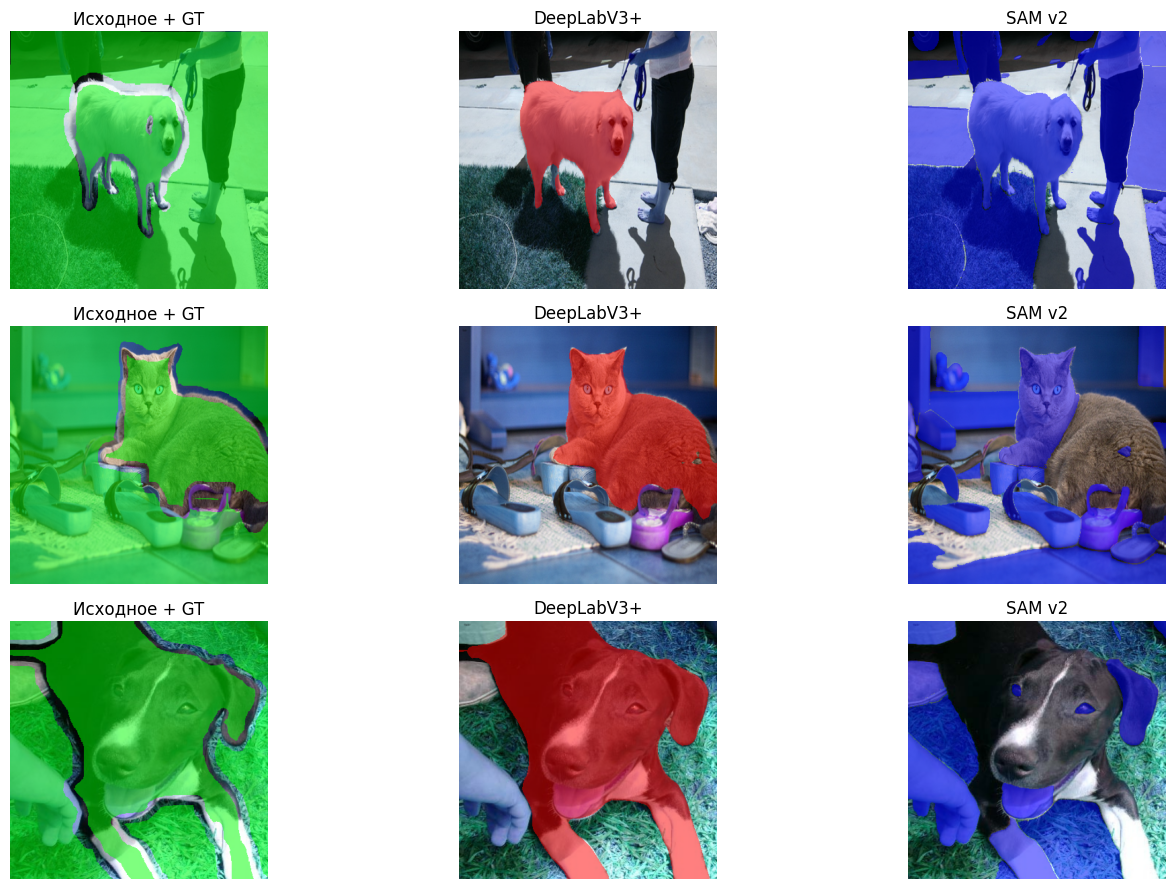

In [ ]:
show_examples(examples)

In [ ]:
## 5. Графическое сравнение кривых обучения

import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs+1))
plt.figure(figsize=(12,5))

# 5.1 Loss curves
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves (Train vs Val)')
plt.legend()

# 5.2 mIoU curves
plt.subplot(1,2,2)
plt.plot(epochs, train_mious, label='Train mIoU')
plt.plot(epochs, val_mious, label='Val mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('mIoU Curves (Train vs Val)')
plt.legend()

plt.tight_layout()
plt.show()

# Задание для самостоятельного обучения
1. Сделайте вывод
1. Дообучение DeepLabV3+: дообучите модель на полном датасете Oxford-IIIT Pet (5–10 эпох), повторите расчёт метрик и визуализацию. Сделайте выводы об улучшении качества.
2. Интерактивный SAM: замените checkpoints на sam_vit_h_4b8939.pth, а SamAutomaticMaskGenerator на SamPredictor и реализуйте простую логику подачи подсказок (точек или прямоугольников). Оцените качество сегментации при 1, 3 и 5 подсказках. Сделайте вывод о прои
3. Анализ ошибок: выберите 5–10 примеров с наименьшим IoU для каждой модели. Визуализируйте их, прокомментируйте возможные причины ошибки (например, сложный фон, мелкие детали).
